In [78]:
import numpy as np
import cv2
import albumentations as A
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.feature import local_binary_pattern

In [79]:
currentPath = Path().cwd()

targetPath = currentPath.parent / 'data' / 'KGT_noDefect_simplified'
imsNoF = [[str(file), False] for file in targetPath.iterdir() if file.is_file()]

targetPath = currentPath.parent / 'data' / 'KGT_pitting_simplified'
imsF = [[str(file), True] for file in targetPath.iterdir() if file.is_file()]

ims = imsNoF + imsF
paths = [x[0] for x in ims]

del(imsNoF, imsF, currentPath, targetPath)

In [80]:
def readImage(path, size=(150,150)):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return cv2.resize(img, size)

In [81]:
def processImage(img):
    # Feature 1: einfache Grayscale
    grayFlat = img.flatten()

    # Feature 2: sobel
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobel = cv2.magnitude(sobelx, sobely)
    sobelFlat = sobel.flatten()

    # Feature 3: Histogramm
    hist = cv2.calcHist([img], [0], None, [16], [0,256])
    hist = cv2.normalize(hist,hist).flatten()

    # Feature 4: LBP (Local Binary Pattern)
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins = np.arange(0,10), range= (0,9), density = True)

    features = np.concatenate([grayFlat,sobelFlat,hist,lbp_hist])
    return features

In [82]:
for i in range(len(ims)):
    processedImage = processImage(readImage(ims[i][0]))
    if processedImage is not None:
        ims[i][0] = processedImage

C:\Users\max\AppData\Local\Temp\ipykernel_27896\1588746660.py:6: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 10.0), p=0.1)


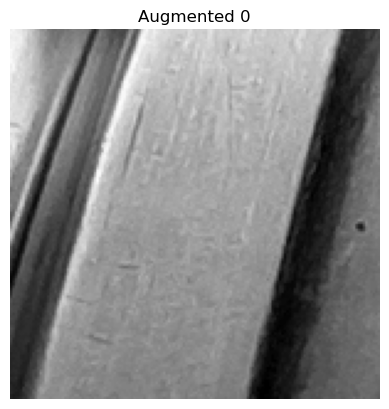

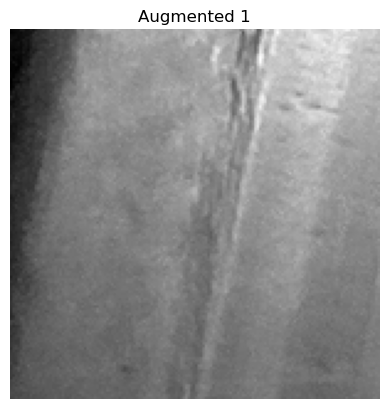

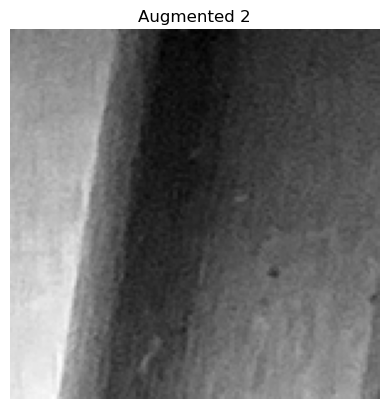

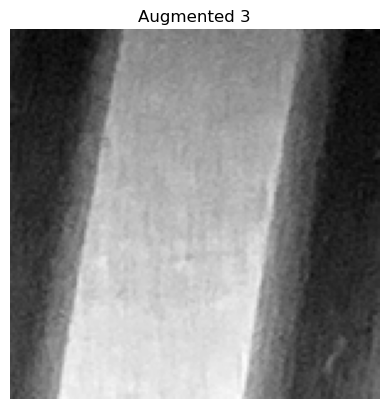

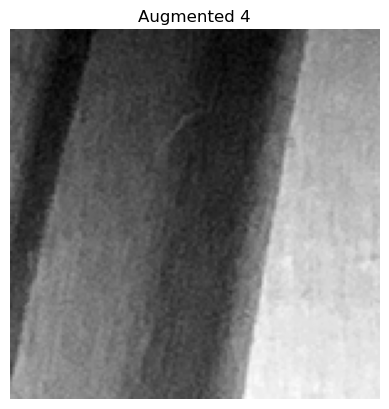

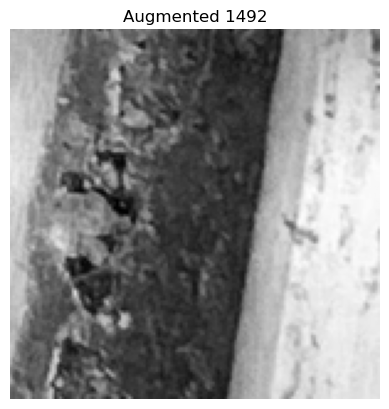

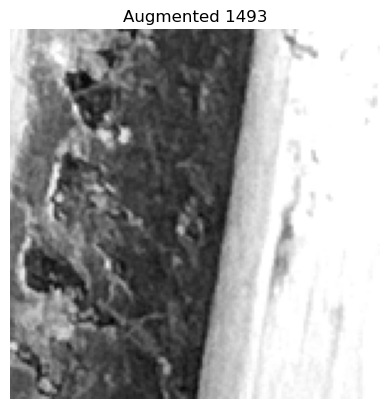

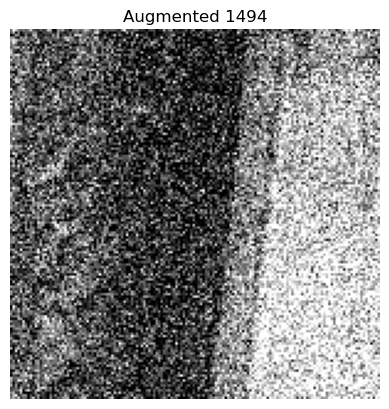

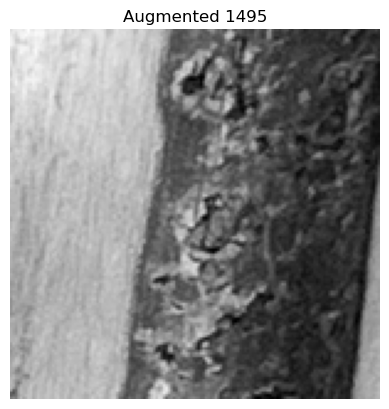

In [83]:
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=(3,3), p=0.1),
    A.GaussNoise(var_limit=(5.0, 10.0), p=0.1)
])

def augmentImage(img):
    return augmenter(image=img)['image']

augIms = []
i = 0
for path in paths:
    img = readImage(path)
    aug_img = augmentImage(img)
    augIms.append(processImage(aug_img))  # Features für Modell
    
    # Bild nur anzeigen – aber das augmentierte Bild, nicht die Features
    if i < 5:
        plt.imshow(aug_img, cmap='gray')
        plt.title(f"Augmented {i}")
        plt.axis('off')
        plt.show()
    elif i > 1491:
        plt.imshow(aug_img, cmap='gray')
        plt.title(f"Augmented {i}")
        plt.axis('off')
        plt.show()
    i+=1    
    


Dieser Block wird für die Benchmark ausgelassen, um den Einfluss dessen nicht mit zu beurteilen.

In [84]:
#augmented = [[augIms[i],ims[i][1]] for i in range(len(augIms))]
#ims = ims + augmented
#del (augIms, augmented, paths)

nachfolgend werden einige andere klassische ml Algorithmen getestet. Die Auswahl ist sicherlich nicht vollständig sinnvoll (KNN...)

In [85]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [86]:
images, labels = zip(*ims)
X = np.array(images)
y = np.array(labels)
XTrain, XTest, yTrain, yTest = train_test_split(X,y, stratify=y, test_size=0.3, random_state=42)

In [87]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(XTrain, yTrain)
yPred = clf.predict(XTest)
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

       False       0.96      0.90      0.93       194
        True       0.93      0.97      0.95       255

    accuracy                           0.94       449
   macro avg       0.94      0.94      0.94       449
weighted avg       0.94      0.94      0.94       449



In [88]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=1),
    "k-NN": KNeighborsClassifier(n_neighbors=3),
    "Logistische Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

for name, model in models.items():
    model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    print(f"\n{name}:")
    print(classification_report(yTest, yPred))


Random Forest:
              precision    recall  f1-score   support

       False       0.96      0.90      0.93       194
        True       0.93      0.97      0.95       255

    accuracy                           0.94       449
   macro avg       0.94      0.94      0.94       449
weighted avg       0.94      0.94      0.94       449


SVM:
              precision    recall  f1-score   support

       False       0.93      0.94      0.94       194
        True       0.96      0.95      0.95       255

    accuracy                           0.94       449
   macro avg       0.94      0.94      0.94       449
weighted avg       0.94      0.94      0.94       449


k-NN:
              precision    recall  f1-score   support

       False       0.88      0.99      0.93       194
        True       0.99      0.90      0.94       255

    accuracy                           0.94       449
   macro avg       0.94      0.95      0.94       449
weighted avg       0.95      0.94      0.94  